__Uses PySurfer to get screenshot images of bootstrapped regression analyses (thresholded at 2) overlayed on Yeo annotation and with bootstrapped mediation analyses thresholded (bootstrap score=1.96) outlines__

In [1]:
%matplotlib inline

In [2]:
import os
from surfer import Brain
import matplotlib.pyplot as plt
import nibabel.freesurfer as fs
import numpy as np

In [16]:
reg_min=2
reg_max=6
def get_image(np_name,meas,
              x_name,
              c_name,
              y_name,
              view,
              hemi):
    #import overlay data, setting nan values to 0
    regfile=(
        'wholebrain_bootstrap_'
        'vertex_regression_'
        '{}_{}_bootscore_{}'
        '.curv'
        .format(np_name,meas,hemi)
    )
    reg_data=fs.read_morph_data(
        '../curvoverlays/'+regfile
    )
    reg_data[np.isnan(reg_data)]=0
    brain = Brain(
        'fsaverage',
        hemi, 
        'inflated',
        cortex="grey", 
        background="white"
    )
    #add image overlay 
    #and hide colorbar
    brain.add_overlay(
        reg_data,
        min=reg_min,
        max=reg_max,
        name='reg'
    )
    brain.overlays["reg"].pos_bar.visible = False
    brain.overlays["reg"].neg_bar.visible = False
    #add Yeo annotation
    brain.add_annotation(
        'Yeo2011_7Networks_N1000',
        alpha=.3
    )
    brain.add_annotation(
        'Yeo2011_7Networks_N1000',
        borders=False,
        alpha=.2,
        remove_existing=False
    )
    #add mediation results as outline 
    #from annotation created 
    #by mri_surfcluster
    medfile=(
        'wholebrain_bootstrap_'
        'vertex_mediation_'
        '{}_{}_x{}_c{}_y{}_'
        'bootscore_{}_cluster.annot'
        .format(np_name,
                meas,
                x_name,
                c_name,
                y_name,
                hemi
               )
    )
    med_annot=fs.read_annot(
        '../curvoverlays/'+
        medfile
    )
    #makes all labels black rgb value
    med_annot[1][:,0:-2]=0 
    brain.add_annotation(
        (med_annot[0],med_annot[1]),
        alpha=1,
        remove_existing=False
    )
    #make image
    brain.show_view(view)
    #get image pixel voxels
    brain_image=brain.screenshot_single() 
    brain.close()
    #remove whitespace
    whitepixels=np.all(
        brain_image==np.array(
            [255,255,255]
        ),
        axis=-1
    )
    rows=[i 
          for i,x 
          in enumerate(
              ~np.all(whitepixels,axis=1)
          ) if x]
    columns=[i 
             for i,x 
             in enumerate(
                 ~np.all(whitepixels,axis=0)
             ) if x]
    return brain_image[
        np.ix_(rows,columns)
    ]

In [17]:
measure_list=['area','thickness']
np_name_list=['ExFunction','Memory']
hemilist=['lh','rh']
viewlist=['lateral','medial']

###### Make snapshot images

In [18]:
%%capture
subplots=[(x,y,z,w) 
          for x in np_name_list 
          for y in hemilist 
          for z in measure_list 
          for w in viewlist]
subplots=[(i,)+x 
          for i,x 
          in enumerate(subplots)]
subplots_images=[
    (i,
     get_image(
         cog,
         meas,
         'Age',
         'Gender',
         cog,
         view,
         hemi
     )
    ) 
    for i,cog,hemi,meas,view 
    in subplots
]

#### Put images into a grid of matplotlib subplots

In [19]:
%%capture
wspace=.05
hspace=.05
f,axes=plt.subplots(
    4,4,
    gridspec_kw={
        'wspace':wspace,
        'hspace':hspace
    }
)
for i,image in subplots_images:
    f.axes[i].imshow(
        image,
        extent=(-1,2,-1,1),
        aspect=1
    )
    f.axes[i].axis('off')

#### Draw lines separating surface area/thickness and np measure

In [20]:
%%capture
#[*left*(x_left), *bottom* (y_bottom),*width*,*height*]
vline=f.add_axes([0,0,1,1])
hline=f.add_axes([0,0,1,1])
vline.axvline(
    x=.5+wspace/4,
    ymax=.85,
    ymin=.15,
    linewidth=2,
    color='black'
)
hline.axhline(
    y=.5+hspace/4,
    xmax=.85,
    xmin=.15,
    linewidth=2,
    color='black'
)
vline.axis('off')
hline.axis('off')

##### Draw color bar

In [21]:
%%capture
#[*left*(x_left), *bottom* (y_bottom),*width*,*height*]
#had to adjust trial/error for tick label positions..
#may want ot do more systematically in future
cbar_axes = (
    f.add_axes([.15, .1, .3, .02]),
    f.add_axes([.57, .1, .3, .02])
)
cbar = np.atleast_2d(np.linspace(-5, 5, 300))
for ax, cmap in zip(
    cbar_axes,
    ["PuBu", "OrRd_r"]
):
    ax.pcolormesh(
        cbar, 
        cmap=cmap, 
        rasterized=True
    )
    ax.set(
        xticks=np.linspace(0, 300, 3), 
        yticks=[]
    )
    ax.xaxis.tick_bottom()
cbar_axes[0].set_xticklabels(
    [-6, -4, -reg_min],
    ha='center'
)
cbar_axes[1].set_xticklabels(
    [reg_min, 4, 6],
    ha='center'
)

#### Make labels for each facet

In [22]:
labelcoords=[(.3,.95,'center','top','horizontal'),
           (.72,.95,'center','top','horizontal'),
           (0.1,.32,'left','center','vertical'),
           (0.1,.75,'left','center','vertical')]
labelnames=['Surface Area',
            'Thickness',
            'Memory',
            'Executive Function']
label_params=[tuple([n])+(p) 
              for p,n 
              in zip(labelcoords,labelnames)]

In [23]:
for s,x,y,ha,va,rot in label_params:
    f.text(
        s=s,
        x=x,
        y=y,
        ha=ha,
        va=va,
        rotation=rot
    )

#### save figure and draw on notebook

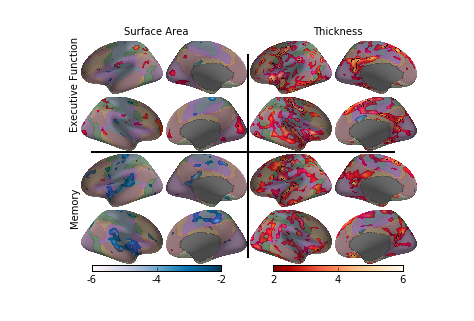

In [24]:
f.savefig(
    '../figures/'
    'wholebrain_mediation_regression.png',
    dpi=300
)
f